In [1]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *
from utils import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False
gpu = 1

In [3]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [4]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import *
# from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_VAEGAN import Encoder
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=latent_dim).cuda(gpu)
# E = Encoder(out_class = latent_dim).cuda(gpu)
E = Discriminator(out_class = latent_dim, is_dis=False).cuda(gpu)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/G_iter188500.pth')) # Alpha-WGAN-GP
# E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./wl_checkpoint_2/G_iter200000.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./vae_checkpoint_1/G_VG_ep_46.pth')) #VAE-GAP
# G.load_state_dict(torch.load('./vae_checkpoint_gp/G_iter29000.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

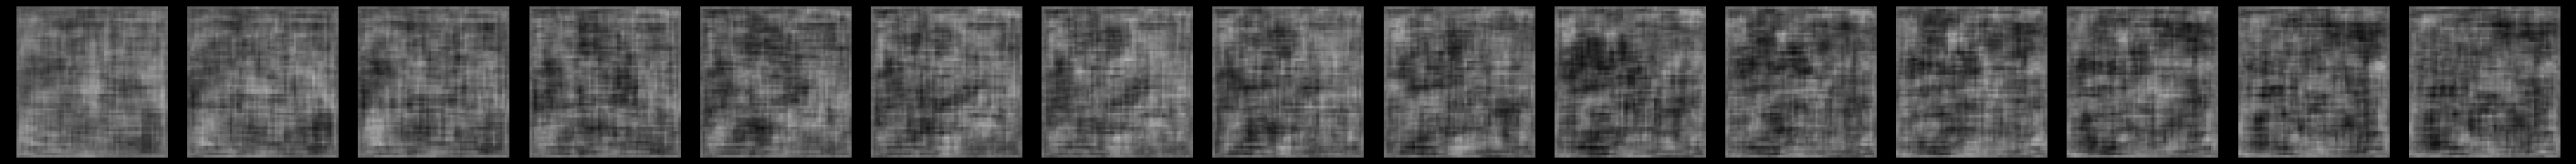

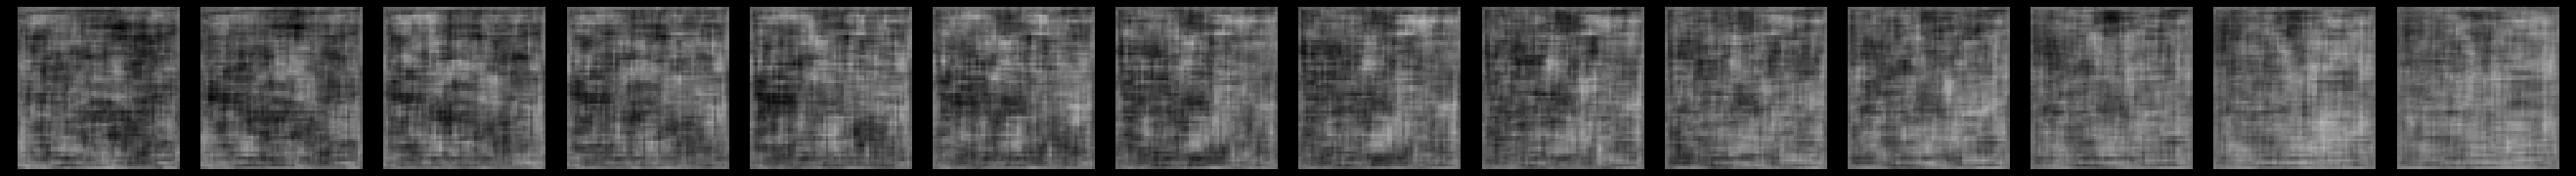

In [5]:
Show_color = False

noise = torch.randn(1, latent_dim).cuda(gpu)
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

In [ ]:
noise = Variable(torch.randn((1, 1000)).cuda(gpu))
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

In [2]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

NameError: name 'trainset' is not defined

# MS-SSIM Calculation

In [11]:
ssim_pth, iteration = 'wl_checkpoint_mse', 100000
E.load_state_dict(torch.load(f'./{pca_pth}/E_iter{iteration}.pth'))
G.load_state_dict(torch.load(f'./{pca_pth}/G_iter{iteration}.pth'))
for i in [1, 10, 100, 1000]:
    calc_ssim(G, i, ssim_pth, no_write=False, gpu=gpu, z_r=i)

1 final ssim: 0.82709801197052
10 final ssim: 0.826937735080719
100 final ssim: 0.8255810141563416
1000 final ssim: 0.8281300067901611


# MS-SSIM Curve

In [ ]:
ssim_pth = 'alpha_checkpoint_2'
last_ind = read_ssim(path=ssim_pth)
last_ind = 1000 if not last_ind else last_ind
inds = [1000] + list(range(5000, 200001, 5000))
for i in inds[inds.index(last_ind):]:
#     G.load_state_dict(torch.load(f'./{ssim_pth}/G_VG_ep_{i}.pth'))
    G.load_state_dict(torch.load(f'./{ssim_pth}/G_iter{i}.pth'))
    calc_ssim(G, i, ssim_pth, no_write=False, gpu=gpu)

final ssim: 0.7942597270011902


In [ ]:
%debug

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)

i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

### calculate averaged mmd score

In [ ]:
mode = 'rbf'
mmd_pth = 'wl_checkpoint_mse'
G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter100000.pth')) 
for i in [1, 10, 100, 1000]:
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False, z_r=i)


iteration: 1, count: 0, Mean: 0.7409857511520386, cost 55.224284410476685 seconds

iteration: 1, count: 1, Mean: 0.7364131808280945, cost 55.42102026939392 seconds

iteration: 1, count: 2, Mean: 0.724463164806366, cost 59.00757122039795 seconds

iteration: 1, count: 3, Mean: 0.7341287732124329, cost 59.91873359680176 seconds

iteration: 1, count: 4, Mean: 0.7188591361045837, cost 62.23776698112488 seconds

iteration: 1, count: 5, Mean: 0.7315586805343628, cost 64.11661052703857 seconds

iteration: 1, count: 6, Mean: 0.7335330843925476, cost 71.12645149230957 seconds

iteration: 1, count: 8, Mean: 0.7374902367591858, cost 56.31722831726074 seconds

iteration: 1, count: 9, Mean: 0.7320287227630615, cost 56.7329797744751 seconds
Total_mean:0.7313181281089782 STD:0.006563735055416319

iteration: 10, count: 0, Mean: 0.7437571883201599, cost 57.36298179626465 seconds

iteration: 10, count: 1, Mean: 0.7371419668197632, cost 56.663920402526855 seconds

iteration: 10, count: 2, Mean: 0.7308951

### create mmd cruve

In [ ]:
mode ='rbf'
mmd_pth = 'wl_checkpoint_mse_2'
last_ind = int(read_mmd(mmd_pth, name=f'{mode}_mmd.csv'))
end = 101000
last_ind = last_ind * 1000 if 'vae' in mmd_pth else last_ind
if not last_ind:
    inds = [1000] + list(range(5000, end, 5000))
elif last_ind == 1000:
    inds = range(5000, end, 5000)
else: 
    inds = range(last_ind + 5000, end, 5000)
for i in inds:
    i = int(i / 1000) if 'vae' in mmd_pth else i
    G.load_state_dict(torch.load(f'./{mmd_pth}/G_iter{i}.pth'))
#     G.load_state_dict(torch.load(f'./{mmd_pth}/G_VG_ep_{i}.pth'))
    calc_mmd(train_loader, G, i, count=10, gpu_ind=gpu, mode=mode, path=mmd_pth, no_write=False)


iteration: 35000, count: 0, Mean: 0.8182598948478699, cost 49.36560559272766 seconds

iteration: 35000, count: 1, Mean: 0.8123144507408142, cost 48.796470403671265 seconds

iteration: 35000, count: 2, Mean: 0.8041270971298218, cost 50.058066844940186 seconds

iteration: 35000, count: 3, Mean: 0.8102261424064636, cost 49.04075288772583 seconds

iteration: 35000, count: 4, Mean: 0.8149036765098572, cost 47.88897371292114 seconds

iteration: 35000, count: 5, Mean: 0.8170410990715027, cost 48.6504282951355 seconds

iteration: 35000, count: 6, Mean: 0.8107104301452637, cost 49.36355185508728 seconds

iteration: 35000, count: 7, Mean: 0.8067456483840942, cost 48.08794045448303 seconds

iteration: 35000, count: 8, Mean: 0.8148290514945984, cost 48.060813903808594 seconds

iteration: 35000, count: 9, Mean: 0.8131070137023926, cost 48.225460052490234 seconds
Total_mean:0.8122264504432678 STD:0.00419816347038111

iteration: 40000, count: 0, Mean: 0.772929310798645, cost 48.41228699684143 second

In [ ]:
%debug

### visualize mmd curve

In [ ]:
df = load_csv('./trained/wl_gan_mmd.csv')
plt.figure()
df['mmd_score'].plot()

### X PCA Visualization

index: 100000, sample_mean: -0.8597016930580139 sample_var: 0.05591288581490517, yellow_mean: -0.8592427372932434 yellow_var: 0.05609549209475517


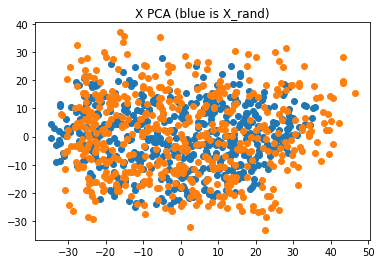

index: 95000, sample_mean: -0.8469794988632202 sample_var: 0.06798743456602097, yellow_mean: -0.8585764169692993 yellow_var: 0.056600846350193024


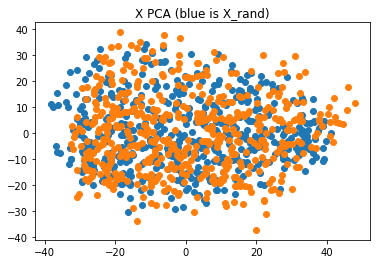

index: 90000, sample_mean: -0.8543906211853027 sample_var: 0.05824235826730728, yellow_mean: -0.8592065572738647 yellow_var: 0.05600983649492264


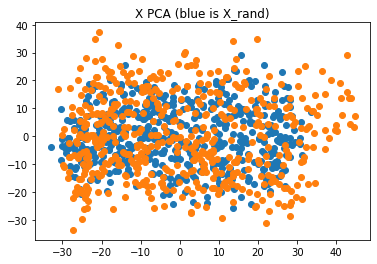

KeyboardInterrupt: 

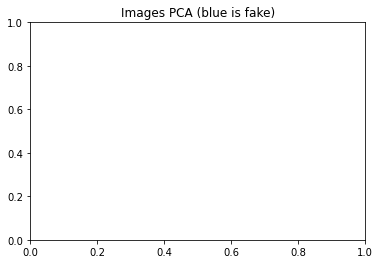

In [35]:
pca_pth = 'wl_checkpoint_2'
for i in range(100000, 0, -5000):
# for i in range(122, -1, -10):
    G.load_state_dict(torch.load(f'./{pca_pth}/G_iter{i}.pth'))
    viz_pca(G, trainset, latent_size=latent_dim, index=i, gpu_ind=gpu)

In [ ]:
def show_pca_cluster(x, PC_list, interval=3):
    for i in range(x, x+interval):
        sample_ind = PC_list[i][2]
        feat = sample_df.iloc[int(sample_ind)].to_numpy().reshape((64, 64, 64))
        featmask = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(featmask, title=f'x_val: {round(PC_list[i][0], 2)} y_val: {round(PC_list[i][1], 2)} sample_index: {int(sample_ind)}')
        plotting.show()

# concatenate the sample index 
PC_list = list(np.concatenate((PCs, np.array([i for i in range(512)]).reshape(512, 1)), 1))
# sort by x or y of PCAs
PC_list.sort(key=lambda x: x[1])

# for i in range(0, 512, 60):
#     show_pca_cluster(i, PC_list, 1)

show_pca_cluster(0, PC_list, 10)



### visualize all training images

In [ ]:
viz_all_imgs('../../ADNI', [0])

### loss check

In [ ]:
loss_df = load_loss(path='wl_checkpoint_2')
# print(loss_df)
# alpha_wgan
plt.figure(figsize=(400, 400))
loss_df[['loss2','gp_h','gp_r',]].plot() 
loss_df[['loss1','l1_loss','d_recon','d_fake','d_real','d_loss',]].plot()
loss_df[['d_recon','d_fake','l1_loss']].plot()
# vae_gan
# loss_df[['d_real_loss', 'd_fake', 'd_recon', 'err_enc']].plot() 

# plt.figure()
# # loss_df[['loss1', 'mmd_loss']].plot()
# plt.figure()
# loss_df[['gp_r', 'gp_h', 'l1_loss']].plot()

In [ ]:
%debug

### Z space pca

<Figure size 432x288 with 0 Axes>

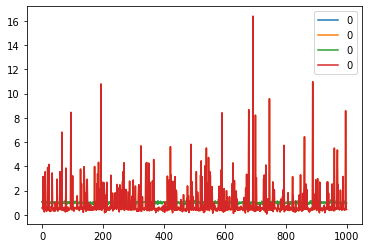

index: 100000, sample_mean: -0.32138165831565857 sample_var: 175.22509765625, yellow_mean: -0.0006970876129344106 yellow_var: 1.0010371208190918


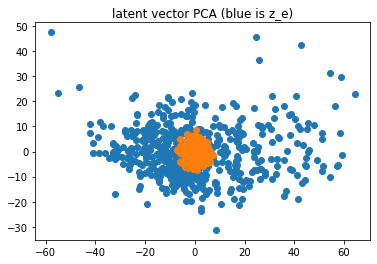

In [37]:
E.load_state_dict(torch.load(f'./wl_checkpoint_mse/E_iter100000.pth'))
for i in [1, 10, 100, 1000]:
    viz_pca(E, trainset, latent_size=latent_dim, index=100000, is_cd=True, gpu_ind=gpu)

In [30]:
%debug

> /usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/modules/conv.py(448)forward()
    446     def forward(self, input):
    447         return F.conv3d(input, self.weight, self.bias, self.stride,
--> 448                         self.padding, self.dilation, self.groups)
    449 
    450 

ipdb> exirt
*** NameError: name 'exirt' is not defined
ipdb> exit


In [ ]:
# for VAEGAN
for i in range(100, -1, -10):
    E.load_state_dict(torch.load(f'./vae_checkpoint_1/E_VG_ep_{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu, batch_size=1)

In [ ]:
# for AlphaWGAN
for i in range(42000, 0, -2000):
    E.load_state_dict(torch.load(f'./wl_checkpoint/E_iter{i}.pth'))
    viz_pca(E, trainset, latent_size=latent_dim, index=i, is_cd=True, gpu_ind=gpu)

# Calculate the paddings of fake images

In [ ]:
G = Generator(noise=1000).cuda(gpu)
G.load_state_dict(torch.load('./trained/G_iter12500.pth'))

def get_padding(feat, axis=0):
    feat = np.swapaxes(feat, 0, axis)
    output = [0, 0]
    for i in range(feat.shape[0]):
#         print(feat[i].sum())
        if feat[i].sum() > -4000:
            output[0] = i
            break
    for i in range(feat.shape[0] - 1, -1, -1):
        if feat[i].sum() > -4000:
            output[1] = feat.shape[0] - i - 1
            break
    return output
    
for i in range(512):
    noise = torch.rand((1, 1000)).cuda(gpu)
    img = G(noise)
    featmask = np.squeeze((0.5*img+0.5).detach().cpu().numpy())
    print(f'ind: {i} padding 0-axis: {get_padding(featmask, 0)}', end=' ')
    print(f'ind: {i} padding 1-axis: {get_padding(featmask, 1)}', end=' ')
    print(f'ind: {i} padding 2-axis: {get_padding(featmask, 2)}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()

### intensity range check

In [ ]:
trainset = ADNIdataset(augmentation=True, img_size=64, normalization=False)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
for featmask in inf_train_gen(train_loader):
#     noise = torch.rand((1, 1000)).cuda()
#     featmask= G(noise)
#     featmask = np.squeeze((0.5*featmask+0.5).detach().cpu().numpy())
    lo, hi = featmask.min(), featmask.max()
    print(f'lo: {lo} hi: {hi}')
#     featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
#     plotting.plot_img(featmask, title=f'ind: {i}')
#     plotting.show()
    

In [ ]:
%debug

In [ ]:
from utils import sinkhorn_pointcloud as sp
import numpy as np
import torch
from ipdb import set_trace
from torch import optim
from torch.autograd import Variable

gpu=1
a = Variable(torch.randn((1000, 4)).cuda(gpu), requires_grad=True)
b = Variable(torch.randn((1000, 4)).cuda(gpu) * 0.01, requires_grad=True) 
g_optimizer = optim.Adam([a, b], lr=0.0002)
print(a.shape, b.shape)
for i in range(1000):
    g_optimizer.zero_grad()
    w_dist = sp.sinkhorn_loss(a, b, 0.1, 1000, 100, gpu=gpu)
    w_dist.backward()
    g_optimizer.step()
    
    if i % 100 == 0:
        print(w_dist)

In [ ]:
a = torch.randn((1, 5), requires_grad=True)
c = a * 2
c.requires_grad = True;
b = c.sum()
b.backward()
print(a.grad)
print(c.grad)
print(b.grad)
